# Домашнее задание

Всего у вас 2 домашних задания:

### 1) Бинарная классификация на примере детекции фрода на кредитных картах (6 баллов)
(в этом файле)

### 2) Небинарная классификация на вашем датасете (6 баллов)
(тоже в этом файле)

# 1 - Бинарная классификация на примере детекции фрода на кредитных картах (суммарно 6 баллов)
У вас есть информация о множесте транзакций. Вам нужно научиться предсказывать, какие из них мошеннические, а какие нет.

### (1 балл) Считайте данные
Сами считайте и предобработайте, если надо, данные из файла creditcard.csv

In [42]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score
from sklearn.utils import compute_class_weight
from sklearn.metrics import roc_curve

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

In [62]:
data = pd.read_csv('creditcard.csv')

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [64]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Посмотрим на распределение классов

In [65]:
Counter(data['Class'])

Counter({0: 284315, 1: 492})

### (2 балла) Обучите несколько моделей, посмотрите на метрики.
Как модели точно возьмите LogisticRegression, KNN и константу, можете придумать еще какие-нибудь.

Как метрики точно возьмите accuracy, precision, recall, f1, roc_auc. Постройте ROC-кривую.

Релизуем класс, который предсказывает константу

In [66]:
class ConstPredictor(BaseEstimator):
    def __init__(self, const_class):
        self.const = const_class

    def fit(self, X, y):
        pass
    
    def predict(self, X_test):
        return self.const*np.ones(X_test.shape[0])

Делим данные на выборки для обучения и для проверки

In [67]:
# Split data into train and test sets
X = data.drop(['Class'], axis=1)
y = data['Class'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [68]:
Counter(y_train)

Counter({0: 227451, 1: 394})

In [69]:
weights = compute_class_weight('balanced', classes=[0,1], y=y_train)
print(weights)

[  0.50086612 289.14340102]


Обучим несколько моделей и сравним их результаты на тестировочном датасете по нескольким метрикам

In [70]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

log_reg_w = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg_w.fit(X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [85]:
y_pred_log_reg = log_reg.predict(X_test)
y_pred_proba_log_reg = log_reg.predict_proba(X_test)

y_pred_log_reg_w = log_reg_w.predict(X_test)
y_pred_proba_log_reg_w = log_reg_w.predict_proba(X_test)

y_pred_const = ConstPredictor(const_class=0).predict(X_test)
y_pred_proba_const = np.stack((np.ones_like(y_pred_const), y_pred_const), axis=-1)

y_pred_knn = knn.predict(X_test)
y_pred_proba_knn = knn.predict_proba(X_test)

Accuracy

In [86]:
print(f'Accuracy score of log reg = {accuracy_score(y_test, y_pred_log_reg):.5f}')
print(f'Accuracy score of weighted log reg = {accuracy_score(y_test, y_pred_log_reg_w):.5f}')
print(f'Accuracy score of const = {accuracy_score(y_test, y_pred_const):.5f}')
print(f'Accuracy score of knn = {accuracy_score(y_test, y_pred_knn):.5f}')

Accuracy score of log reg = 0.99916
Accuracy score of weighted log reg = 0.96125
Accuracy score of const = 0.99828
Accuracy score of knn = 0.99833


Из-за несбалансированности данных, примитивный классификатор имеет **accuracy** 99%. knn, log-reg с дефолтными параметрами и прмитивный классификаторы отличаются только в 4 знаке. На удивление, accuracy взвешанной логистической регрессии меньше всех.

Precison

In [87]:
print(f'Precison score of log reg = {precision_score(y_test, y_pred_log_reg):.5f}')
print(f'Precison score of weighted log reg = {precision_score(y_test, y_pred_log_reg_w):.5f}')
print(f'Precison score of const = {precision_score(y_test, y_pred_const):.5f}')
print(f'Precison score of knn = {precision_score(y_test, y_pred_knn):.5f}')

Precison score of log reg = 0.82051
Precison score of weighted log reg = 0.03932
Precison score of const = 0.00000
Precison score of knn = 1.00000


/home/shamil/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Precsion** у примитивного классификатора 0, потому что происходит деление на 0 (у precision в знаминателе стоит количество предсказанных 1). Снова, удивляет взвешанная логистическая регрессия, у которой precison минимальный

Recall

In [88]:
rec_log_reg = recall_score(y_test, y_pred_log_reg)
rec_log_reg_w = recall_score(y_test, y_pred_log_reg_w)
rec_const = recall_score(y_test, y_pred_const)
rec_knn = recall_score(y_test, y_pred_knn)

print(f'Recall score of log reg = {rec_log_reg:.5f}')
print(f'Recall score of weighted log reg = {rec_log_reg_w:.5f}')
print(f'Recall score of const = {rec_const:.5f}')
print(f'Recall score of knn = {rec_knn:.5f}')

Recall score of log reg = 0.65306
Recall score of weighted log reg = 0.91837
Recall score of const = 0.00000
Recall score of knn = 0.03061


**Recall** примитивного классификатора 0 (в числителе количестве предсказанных 1). Лучший скор у взвешанной лог регресси, как и можно было ожидать.

F1

In [89]:
f1_log_reg = f1_score(y_test, y_pred_log_reg)
f1_log_reg_w = f1_score(y_test, y_pred_log_reg_w)
f1_const = f1_score(y_test, y_pred_const)
f1_knn = f1_score(y_test, y_pred_knn)

print(f'F1 score of log reg = {f1_log_reg:.5f}')
print(f'F1 score of weighted log reg = {f1_log_reg_w:.5f}')
print(f'F1 score of const = {f1_const:.5f}')
print(f'F1 score of knn = {f1_knn:.5f}')

F1 score of log reg = 0.72727
F1 score of weighted log reg = 0.07541
F1 score of const = 0.00000
F1 score of knn = 0.05941


Хотя в взвешанной лог регрессии был хороший recall, из-за плохого precision F1 score у него маленький. Самый лучший у лог регрессии с дефолтными параметрами.

ROC-AUC

In [90]:
ra_log_reg = roc_auc_score(y_test, y_pred_log_reg)
ra_log_reg_w = roc_auc_score(y_test, y_pred_log_reg_w)
ra_const = roc_auc_score(y_test, y_pred_const)
ra_knn = roc_auc_score(y_test, y_pred_knn)

print(f'ROC-AUC score of log reg = {ra_log_reg:.5f}')
print(f'ROC-AUC score of weighted log reg = {ra_log_reg_w:.5f}')
print(f'ROC-AUC score of const = {ra_const:.5f}')
print(f'ROC-AUC score of knn = {ra_knn:.5f}')

ROC-AUC score of log reg = 0.82641
ROC-AUC score of weighted log reg = 0.93985
ROC-AUC score of const = 0.50000
ROC-AUC score of knn = 0.51531


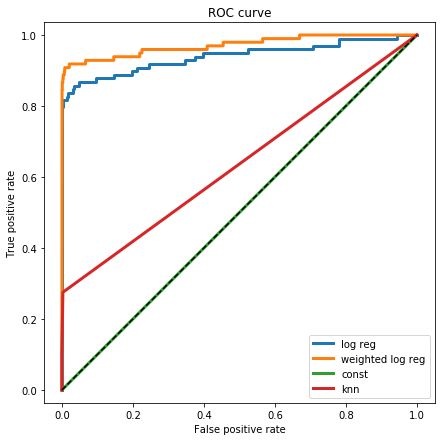

In [91]:
plt.figure(figsize=(7, 7))
fpr_lgr, tpr_lgr, thresholds_lgr = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_wlgr, tpr_wlgr, thresholds_wlgr = roc_curve(y_test, y_pred_proba_log_reg_w[:,1])
fpr_c, tpr_c, thresholds_c = roc_curve(y_test, y_pred_proba_const[:,1])
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_proba_knn[:,1])

plt.plot(fpr_lgr, tpr_lgr, linewidth=3, label='log reg')
plt.plot(fpr_wlgr, tpr_wlgr, linewidth=3, label='weighted log reg')
plt.plot(fpr_c, tpr_c, linewidth=3, label='const')
plt.plot(fpr_knn, tpr_knn, linewidth=3, label='knn')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.axis('equal')
plt.title('ROC curve')
plt.show()

### (1 балл) Выберите одну метрику, которую вы будете максимизировать

Представьте, что вы решаете задачу автоматического поиска мошеннических транзакций, чтобы ваш робот автоматически банил пользователей, который их осуществляют.

Обоснуйте свой выбор.

Так как для нас важно не упустить мошенников, то есть минимизировать false negatives. Поэтому подходящей метрикой будет **recall score**. С другой стороны, не стоит забывать, что максимизируя **racall** мы не хотим переобучить модель и предсказывать все транзакции как мошеннические. 

In [138]:
f2_log_reg = recall_score(y_test, y_pred_log_reg)
f2_log_reg_w = recall_score(y_test, y_pred_log_reg_w)
print(f"Recall score log reg = {f2_log_reg:.5f}")
print(f"Recall score weighted log reg = {f2_log_reg_w:.5f}")

Recall score log reg = 0.65306
Recall score weighted log reg = 0.91837


### (2 балла) Переберите гиперпараметры разных моделей, попытайтесь добиться лучшего результата по этой метрике

Постройте график для каждого перебора, сделайте красивый отчет (не надо просто говорить "я решил выбрать 2, 0.7 и 6, так не пойдет".

Можно преобразовывать датасет, преобразовывать, добавлять, удалять фичи, всё что угодно.

Отсутствие результата тоже результат (вдруг вы перебрали кучу вещей, а лучший все еще самый первый запуск, главное что перебрали).

In [93]:
f2_scorer = metrics.make_scorer(fbeta_score, beta=2)

Воспользуемся **StratifiedKFold** в **cross_val_score** чтобы разделение на фолды было равномерным

In [130]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

У нас очень много данных класса 0, поэтому мы долго обучаемся и переобучаемся. Попробуем рандомно выкинуть выборки из класса 0, и добавим выборки класса 1. Это ускорит время обучения и переобучение

In [155]:
imba_pipeline_r = make_pipeline(RandomUnderSampler(sampling_strategy=0.1, random_state=42),
                            RandomOverSampler(sampling_strategy='minority', random_state=42),
                            LogisticRegression(penalty='l2', max_iter=1e3, random_state=42))

imba_pipeline_s = make_pipeline(RandomUnderSampler(sampling_strategy=0.1, random_state=42),
                            SMOTE(sampling_strategy='minority', random_state=42),
                            LogisticRegression(penalty='l2', max_iter=1e3, random_state=42))

In [156]:
cv_score_r = cross_val_score(imba_pipeline_r, X_train, y_train, cv=skf, scoring='recall')
cv_score_s = cross_val_score(imba_pipeline_s, X_train, y_train, cv=skf, scoring='recall')

print(f"Recall cross validation score lgr with random under and over sampling = {np.mean(cv_score_r):.5f}")
print(f"Recall cross validation score lgr with random under sampling and SMOTE = {np.mean(cv_score_r):.5f}")

Recall cross validation score lgr with random under and over sampling = 0.89104
Recall cross validation score lgr with random under sampling and SMOTE = 0.89104


Результат лучше не стал, и разницы между подходами (random oversampling vs SMOTE) нет

In [157]:
lambdas_l2 = np.linspace(1, 5, 20)
params = {'logisticregression__C':1/lambdas_l2}

grid_imba = GridSearchCV(imba_pipeline_r, param_grid=params, cv=skf, scoring='recall',
                        return_train_score=True)
grid_imba.fit(X_train, y_train);

Bes score = 0.90357, best param = 2.47368


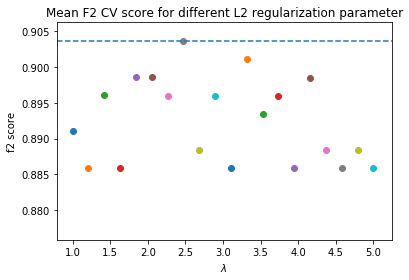

In [158]:
print(f"Bes score = {grid_imba.best_score_:.5f}, best param = {1/grid_imba.best_params_['logisticregression__C']:.5f}")

_, ax = plt.subplots()
for lr, cv in zip(lambdas_l2, grid_imba.cv_results_['mean_test_score'].tolist()):
    ax.scatter(lr, cv)
ax.axhline(grid_imba.best_score_, linestyle='dashed')
ax.set_title('Mean recall CV score for different L2 regularization parameter')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'recall score')
plt.show()

Я пробовал другие диапазоны для $\lambda$, лучшие скоры получаются в диапазоны от 4 до 8, поэтому рассматриваю их. Но в целом изменение коэффициентов L2 регуляризации не привело к существенному улучшению скора. Попробуем другу регуляризацию - L1

In [159]:
imba_pipeline_rl1 = make_pipeline(RandomUnderSampler(sampling_strategy=0.1, random_state=42),
                            RandomOverSampler(sampling_strategy='minority', random_state=42),
                            LogisticRegression(penalty='l1', max_iter=1e3, random_state=42, solver='liblinear'))

In [163]:
lambdas_l1 = np.linspace(0.1, 5, 20)
params = {'logisticregression__C':1/lambdas_l1}

grid_imba = GridSearchCV(imba_pipeline_rl1, param_grid=params, cv=skf, scoring='recall',
                        return_train_score=True)
grid_imba.fit(X_train, y_train);

Bes score = 0.91126, best param = 0.35789


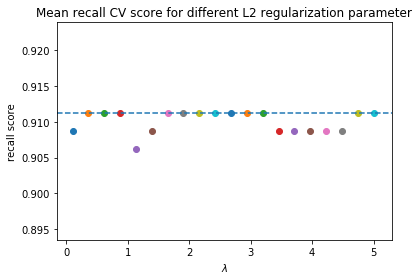

In [164]:
print(f"Bes score = {grid_imba.best_score_:.5f}, best param = {1/grid_imba.best_params_['logisticregression__C']:.5f}")

_, ax = plt.subplots()
for lr, cv in zip(lambdas_l1, grid_imba.cv_results_['mean_test_score'].tolist()):
    ax.scatter(lr, cv)
ax.axhline(grid_imba.best_score_, linestyle='dashed')
ax.set_title('Mean recall CV score for different L2 regularization parameter')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'recall score')
plt.show()

Модель с L1 регуляризацией немного лучше чем L2

In [167]:
# Final model
y_pred = grid_imba.best_estimator_.named_steps['logisticregression'].predict(X_test)

print(f'Recall score on test set of the final model = {recall_score(y_test, y_pred):.5f}')

Recall score on test set of the final model = 0.91837


К сожалениб, после всех модификаций мы получили такой же результат как у взвешанной линейной регрессии

# 2 - Небинарная классификация на вашем датасете (суммарно 6 баллов)

### (2 балла) Выберите какой-нибудь интересный вам датасет, скачайте его и считайте данные

Творческое задание - найти в интернете (или собрать свой даже) датасет, сохранить его в файл, и загрузить сюда.

Требования:

- он должен быть немаленький (хотя бы 500 объектов, лучше больше)
- он должен быть интересный
- таргет должен быть небинарным классом

Минус балл, если ваш датасет с кем-нибудь повторится.

Данные, которые я выбрал для небинарной классификации: [датасет с дрожжами](https://archive.ics.uci.edu/ml/datasets/Yeast), где надо предсказывать участки клеточной локализации белка. Всего 8 признаков и 10 выходных классов.

In [70]:
data_yeast = pd.read_csv('yeast.csv')

In [71]:
data_yeast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mcg                         1484 non-null   float64
 1   gvh                         1484 non-null   float64
 2   alm                         1484 non-null   float64
 3   mit                         1484 non-null   float64
 4   erl                         1484 non-null   float64
 5   pox                         1484 non-null   float64
 6   vac                         1484 non-null   float64
 7   nuc                         1484 non-null   float64
 8   class_protein_localization  1484 non-null   object 
dtypes: float64(8), object(1)
memory usage: 104.5+ KB


In [72]:
data_yeast.rename(columns={'class_protein_localization':'target'}, inplace=True)
data_yeast.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


Закодируем выходные классы (из букв в цифры), так как алгоритмам удобнее работать с числовыми значениями.

In [73]:
le = LabelEncoder()
data_yeast['target'] = le.fit_transform(data_yeast['target'])

In [74]:
print(Counter(data_yeast['target']))

Counter({0: 463, 7: 429, 6: 244, 5: 163, 4: 51, 3: 44, 2: 35, 9: 30, 8: 20, 1: 5})


### (2 балла) Обучите несколько моделей, посмотрите на метрики.
Как модели точно возьмите LogisticRegression, KNN и константу, можете придумать еще какие-нибудь.

Как метрики точно возьмите accuracy, разные усреднения precision, recall и f1.

Разделим данные на тренировочную и тестовую выборки

In [75]:

X_yeast = data_yeast.drop('target', axis=1)
y_yeast = data_yeast['target'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_yeast, y_yeast, test_size=0.2, random_state=42, stratify=y_yeast)

Обучим несколько моделей

In [76]:
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
weights

array([ 0.32081081, 29.675     ,  4.23928571,  3.39142857,  2.89512195,
        0.90610687,  0.60871795,  0.34606414,  7.41875   ,  4.94583333])

In [77]:
dummy = DummyClassifier(strategy='most_frequent')
lr = LogisticRegression(max_iter=1e+3, random_state=42, multi_class='ovr')
wlr = LogisticRegression(max_iter=1e+3, random_state=42, multi_class='ovr', class_weight='balanced')
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

dummy.fit(X_train, y_train)
lr.fit(X_train, y_train)
wlr.fit(X_train, y_train)
knn.fit(X_train, y_train);

Протестим модели на тестовой выборке

In [78]:
y_pred_dummy = dummy.predict(X_test)
y_pred_lr = lr.predict(X_test)
y_pred_wlr = wlr.predict(X_test)
y_pred_knn = knn.predict(X_test)

y_pred_proba_dummy = dummy.predict_proba(X_test)
y_pred_proba_lr = lr.predict_proba(X_test)
y_pred_proba_wlr = wlr.predict_proba(X_test)
y_pred_proba_knn = knn.predict_proba(X_test)

In [79]:
classifiers = ['dummy', 'logit', 'wlogit', 'knn']
accs = [accuracy_score(y_test, y_pred) for y_pred in [y_pred_dummy, y_pred_lr, y_pred_wlr, y_pred_knn]]
d = dict(zip(classifiers, accs))
acc_df = pd.DataFrame(data=d, index=['accuracy'])
acc_df

,dummy,logit,wlogit,knn
accuracy,0.313131,0.565657,0.515152,0.542088


In [80]:
def get_precision_scores(y_true, y_pred):
    avs = ['micro', 'macro', 'weighted']
    scores = [precision_score(y_true, y_pred, average=x) for x in avs]
    return scores

def get_recall_scores(y_true, y_pred):
    avs = ['micro', 'macro', 'weighted']
    scores = [recall_score(y_true, y_pred, average=x) for x in avs]
    return scores

def get_f1_scores(y_true, y_pred):
    avs = ['micro', 'macro', 'weighted']
    scores = [f1_score(y_true, y_pred, average=x) for x in avs]
    return scores

In [81]:
prcns = [get_precision_scores(y_test, y_pred) for y_pred in [y_pred_dummy, y_pred_lr, y_pred_wlr, y_pred_knn]]
d = dict(zip(classifiers, prcns))
pr_df = pd.DataFrame(data=d, index=['p micro', 'p macro', 'p weighted'])
pr_df

/home/shamil/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shamil/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shamil/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shamil/.local/lib/python3.6/site-packages/sklearn/metrics/_classification

,dummy,logit,wlogit,knn
p micro,0.313131,0.565657,0.515152,0.542088
p macro,0.031313,0.419915,0.535808,0.583730
p weighted,0.098051,0.549236,0.565098,0.546414


In [82]:
recs = [get_recall_scores(y_test, y_pred) for y_pred in [y_pred_dummy, y_pred_lr, y_pred_wlr, y_pred_knn]]
d = dict(zip(classifiers, recs))
rc_df = pd.DataFrame(data=d, index=['r micro', 'r macro', 'r weighted'])
rc_df

,dummy,logit,wlogit,knn
r micro,0.313131,0.565657,0.515152,0.542088
r macro,0.100000,0.313761,0.533576,0.508235
r weighted,0.313131,0.565657,0.515152,0.542088


In [83]:
f1s = [get_f1_scores(y_test, y_pred) for y_pred in [y_pred_dummy, y_pred_lr, y_pred_wlr, y_pred_knn]]
d = dict(zip(classifiers, recs))
f1_df = pd.DataFrame(data=d, index=['f1 micro', 'f1 macro', 'f1 weighted'])
f1_df

,dummy,logit,wlogit,knn
f1 micro,0.313131,0.565657,0.515152,0.542088
f1 macro,0.100000,0.313761,0.533576,0.508235
f1 weighted,0.313131,0.565657,0.515152,0.542088


### (2 балла) Выберите метрику, которую вы хотите максимизировать. Переберите гиперпараметры, постарайтесь найти модель, которая максимизирует эту метрику.

Обоснуйте свой выбор. Напишите красивый отчет с графиками. Добились ли вы результатов, которых хотели добиться для этого датасета?

Аналогично бинарной классификации, данные несбалансированы. Поэтому выбранные модели могут легко переобучиться и плохо классифицировать некоторые классы (которых мало в тренировочной выборке). Чтобы не упускать редкие классы важно сделать акцент на recall, но с другой стороны не хочется сильно терять в precision, поэтому в качестве метрики будем использовать F2 score.  Для сранения разных моделей и/или гиперпараметров воспользуемся **cross_validation_score**

Подсчитаем скор для простых моделей

In [84]:
print(Counter(y_train))

Counter({0: 370, 7: 343, 6: 195, 5: 131, 4: 41, 3: 35, 2: 28, 9: 24, 8: 16, 1: 4})


In [85]:
est_logit = LogisticRegression(max_iter=1e+3, multi_class='ovr', random_state=42)
est_wlogit = LogisticRegression(max_iter=1e+3, multi_class='ovr', random_state=42, class_weight='balanced')

f2_scorer = metrics.make_scorer(fbeta_score, beta=2, average='micro')
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

f2_cv_score_logit = cross_val_score(est_logit, X_train, y_train, cv=skf, scoring=f2_scorer)
f2_cv_score_wlogit = cross_val_score(est_wlogit, X_train, y_train, cv=skf, scoring=f2_scorer)

print(f'Average cross validation F2 score logit = {np.mean(f2_cv_score_logit):.5f}')
print(f'Average cross validation F2 score weighted logit = {np.mean(f2_cv_score_wlogit):.5f}')

Average cross validation F2 score logit = 0.52149
Average cross validation F2 score weighted logit = 0.52656


Попробуем oversampling

In [86]:
imba_pipeline_l2 = make_pipeline(RandomOverSampler(sampling_strategy='not majority', random_state=42),
                            LogisticRegression(penalty='l2', max_iter=1e3, random_state=42, solver='lbfgs'))

In [87]:
F2_cv_score = cross_val_score(imba_pipeline_l2, X_train, y_train, cv=skf, scoring=f2_scorer)
print(f"F2 score with oversampling = {np.mean(F2_cv_score):.5f}")

F2 score with oversampling = 0.51897


Oversampling не привел к улучшению скора. Рассмотрим распределение признаков

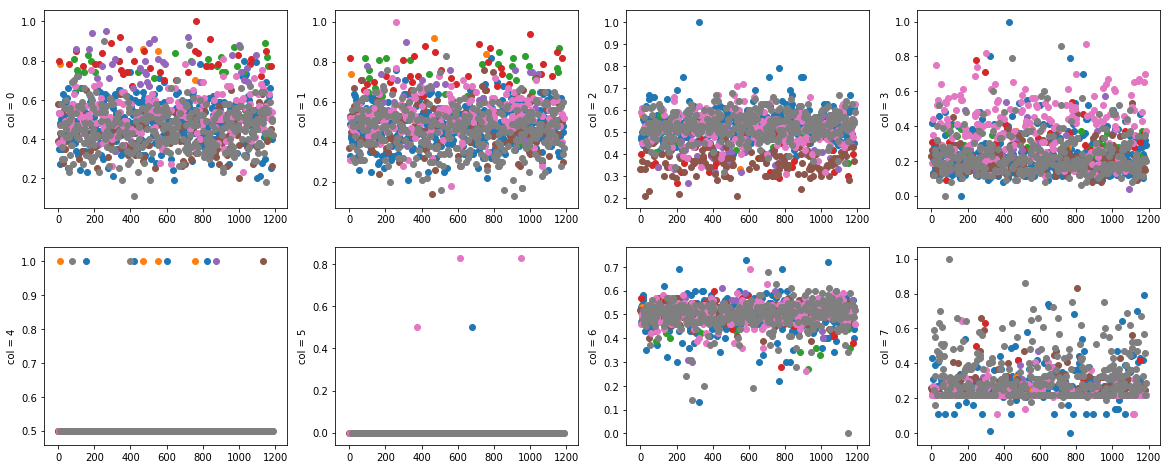

In [88]:
_, axs = plt.subplots(2,4, figsize=(20,8))
tx = np.arange(0, X_train.shape[0])
for k, ax in enumerate(axs.reshape(-1)):
    for j in range(8):
        idxs = y_train==j
        ax.scatter(tx[idxs], X_train.to_numpy()[idxs,k])
    # ax.scatter(tx, X_train.to_numpy()[:,k])
    ax.set_ylabel(f'col = {k}')

plt.show()

С первого взгляда тяжело что-то сказать о распеределении, но видно, что классы линейно не разделимы. Попробуем добавить полиномиальные признаки

In [89]:
poly = PolynomialFeatures(2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

F2_cv_score_poly = cross_val_score(est_wlogit, X_train_poly, y_train, cv=skf, scoring=f2_scorer)
print(f"F2 CV score with polynomial features = {np.mean(F2_cv_score_poly):.5f}")

F2 CV score with polynomial features = 0.52655


Полиномиальные признаки не привели к увеличению скора. Попробуем отбросить некоторые признаки.

In [90]:
selector = RFECV(est_wlogit, step=1, cv=skf)
selector = selector.fit(X_train, y_train)
X_train_red = selector.transform(X_train)
print(f"Number of eliminated features = {X_train.shape[1] - X_train_red.shape[1]}")
print(f"F2 score for reduced dataset = {np.max(selector.grid_scores_):.5f}")

Number of eliminated features = 1
F2 score for reduced dataset = 0.53244


Избавившись от одного из признаков нам удалось незначительно увеличить скор. Теперь попробуем поменять параметры регуляризации

In [91]:
lambdas_l2 = np.linspace(0.01, 3, 20)
params_4l2 = {'penalty':['l2'],
                'C':1/lambdas_l2}

grid_l2 = GridSearchCV(est_wlogit, param_grid=params_4l2, cv=skf, scoring=f2_scorer,
                        return_train_score=True)
grid_l2.fit(X_train_red, y_train);

Bes score = 0.53329, best param = 0.63947


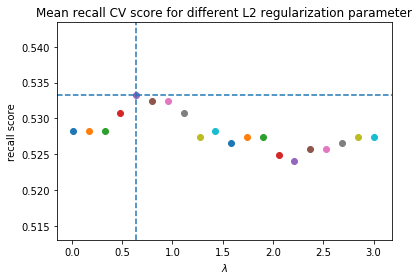

In [92]:
best_labmda_l2 = 1/grid_l2.best_params_['C']
print(f"Bes score = {grid_l2.best_score_:.5f}, best param = {best_labmda_l2:.5f}")

_, ax = plt.subplots()
for lr, cv in zip(lambdas_l2, grid_l2.cv_results_['mean_test_score'].tolist()):
    ax.scatter(lr, cv)
ax.axhline(grid_l2.best_score_, linestyle='dashed')
ax.axvline(best_labmda_l2, linestyle='dashed')
ax.set_title('Mean recall CV score for different L2 regularization parameter')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'recall score')
plt.show()

In [93]:
lambdas_l1 = np.linspace(0.01, 5, 20)
params_4l1 = {'penalty':['l1'],
            'solver':['liblinear'],
            'C':1/lambdas_l1}

grid_l1 = GridSearchCV(est_wlogit, param_grid=params_4l1, cv=skf, scoring=f2_scorer,
                        return_train_score=True)
grid_l1.fit(X_train_red, y_train);

Bes score = 0.57119, best param = 2.37368


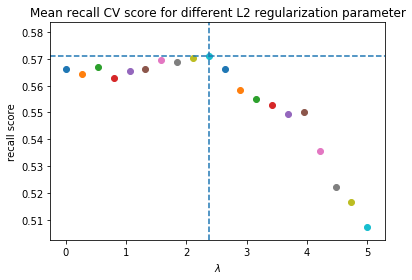

In [94]:
best_C_l1 = grid_l1.best_params_['C']
best_labmda_l1 = 1/best_C_l1
print(f"Bes score = {grid_l1.best_score_:.5f}, best param = {best_labmda_l1:.5f}")

_, ax = plt.subplots()
for lr, cv in zip(lambdas_l1, grid_l1.cv_results_['mean_test_score'].tolist()):
    ax.scatter(lr, cv)
ax.axhline(grid_l1.best_score_, linestyle='dashed')
ax.axvline(best_labmda_l1, linestyle='dashed')
ax.set_title('Mean recall CV score for different L2 regularization parameter')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'recall score')
plt.show()

L1 регуляризация приводит к значительному увеличению метрики, а L2 нет. Прогоним через лучшую модель тестовую выборку

In [96]:
lr_final = LogisticRegression(penalty='l1', C=best_C_l1, class_weight='balanced', random_state=42, solver='liblinear')
lr_final.fit(X_train_red, y_train)

X_test_red = selector.transform(X_test)
y_pred = lr_final.predict(X_test_red)


f2_score = fbeta_score(y_test, y_pred, beta=2, average='micro')
print(f"F2 score of the final model = {f2_score:.5f}")

F2 score of the final model = 0.55892
